# Homework - Deep learning for image classification


Let's train network to classify images from Tiny ImageNet!

Your homework contains three parts:

1. Make yourself familiar with ordinary training script structure and train good old vgg-like network
2. Improve quality with resnet-like network
3. Improve quality with test-time augmentation

But first of all let's take a look on data

# Tiny ImageNet dataset
In this homework we shall focus on the image recognition problem on Tiny Image Net dataset. This dataset contains
* 100k images of shape 3x64x64
* 200 different classes: snakes, spiders, cats, trucks, grasshopper, gull, etc.

In fact, it is a subset of ImageNet dataset with 4x downscaled images.

## Image examples



<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim3.png?raw=1" alt="Drawing" style="width:90%"/> </td>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim2.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>


<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tiniim.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>

## Step 0 - data loading

In [1]:
#!S:bash
# if you are in colab, just add '!' in the start of the following line
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

--2024-03-10 13:58:36--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 813 [text/plain]
Saving to: 'tiny_img.py'

tiny_img.py         100%[===================>]     813  --.-KB/s    in 0s      

2024-03-10 13:58:36 (37.1 MB/s) - 'tiny_img.py' saved [813/813]

--2024-03-10 13:58:37--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response

In [2]:
#!L
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

Dataset was downloaded to './tiny-imagenet-200.zip'
Extract downloaded dataset to '.'


## Part 1. Training script structure and vgg-like network

In order to train a neural network for a specific task you should write code for 4 task-specific blocks and for one task-independed block:
1. data loader (data provider) - how to load and augment data for nn training
2. neural network architecture - what will be trained
3. loss function (+ auxilary metrics on train and validation set) - how to check neural network quality
4. optiimzer and training schedule - how neural network will be trained
5. "Train loop" - what exactly to do for each batch, how often to check validation error, how often to save network and so on. This code could be written in general way and reused between different training scripts


In [3]:
#!L
import torch
import torchvision
from torchvision import transforms
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


### 1.1 Data loader and data augmentation
Normally there are two connected abstractions for data manipulation:
- Dataset (`torch.utils.data.Dataset` and its subclasses from `torchvision.datasets`) - some black-box that keeps and preprocesses separate elements of dataset. In particular, single sample augmentations live on this level usually.
- DataLoader (`torch.utils.data.DataLoader`) - structure that combines separate elements in batch.

Let's deal with training dataset. Here are some simple augmentations that we are going to use in our experiments:

In [4]:
train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ]
)

For training dataset we will use custom dataset that will keep all training data in RAM. If your amount of RAM memory is low, you can use `torchvision.datasets.ImageFolder()` instead.

In [5]:
#!L
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


Now validation. Take a look at `tiny-imagenet-200/val` folder and compare it with `tiny-imagenet-200/train`. Looks different, right? So we can't use `TinyImagenetRAM` for loading the validation set. Let's write a custom dataset instead but with the same behavior like `TinyImagenetRAM`.

In [6]:
from torch.utils.data import Dataset
import os
from PIL import Image

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        # 1. define self.classes - list of sorted class labels from annotations
        # it should look like self.classes from "TinyImagenetRAM"
        self.classes = sorted(list(set(annotation[1] for annotation in annotations)))

        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        # 2. self.class_to_idx - dict from class label to class index
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
            # store the class index in self.targets
            image = tiny_img_dataset.read_rgb_image(img_name)

            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # take image and its target label from "self.images" and "self.targets",
        # transform the image using self.transform and return the transformed image and its target label

        image = self.images[index]
        image = self.transform(image)
        target = self.targets[index]

        return image, target

Let's finally load validation dataset. Normally you don't need to augment validation data.

In [7]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:09<00:00, 1053.26it/s]


For the most cases the default `DataLoader` will be good enough.

In [16]:
#!L
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=12)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
#!L
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=12)

### 1.2 Neural network definition

"VGG-like network" usually means that the network is a sequence of convolutions with MaxPooling for downsampling. Here is a table from the original paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556) that describes classical configurations of VGG networks (often referred as VGG-A, VGG-B and so on using column name as an identificator or as VGG16, VGG19 and so on using amount of layers as an identificator)
![image.png](https://pytorch.org/assets/images/vgg.png)

These network configurations were designed for ImageNet dataset. Since images in tiny-imagenet are 4x downsampled, we are going to design our own configuration by reducing: 1) amount of layers; 2) amount of neurons in layers; 3) amount of maxpooling layers which downsample feature maps

Our network config will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

We use Conv(128) and GlobalAveragePooling instead of image flattening and FC layers for reducing the amount of parameters.

In [17]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

And one more thing. VGG was designed before BatchNormalization was introduced. Nowadays it will be stupid if we don't use batch normalization in our network. So let's define simple module containing convolution, batch norm and relu in it and build our network using this module. Here is also implementation of GlobalAveragePooling given for you as example of custom module.

In [18]:
#!L
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)


class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        return x


def create_vgg_like_network(config=None):
    """
    Creates VGG like network according to config
    """
    model = nn.Sequential()

    default_config = [[16,16], [32, 32], [64, 64], [128, 128]]
    config = config or default_config

    in_channels = 3
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]

            model.add_module(f"ConvNBRelu {block_index}_{layer_index_in_block}", ConvBNRelu(in_channels, out_channels, 3))

            in_channels = out_channels

        if block_index != len(config) - 1:
            model.add_module(f'mp_{block_index}', nn.MaxPool2d(3, stride=2))

    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Here are our model created!

In [85]:
model = create_vgg_like_network()
model = model.to(device)

### 1.3 Loss function definition

Usually cross-entropy (negative log-likelihood) is used as loss function for image classification.

In [20]:
#!L
def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

### 1.4 Optimizer and training schedule

In [86]:
opt = torch.optim.Adam(model.parameters())

### 1.5 Training loop

Let's combine the previously defined things together.

In [52]:
import numpy as np
import time


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)


def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        opt.zero_grad()

        # forward
        # YOUR CODE: move X_batch, y_batch to 'device', compute model outputs on X_batch,
        # run `compute_loss()` function
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)
        loss = compute_loss(predictions, y_batch)

        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train_model(model, optimizer, train_data_generator)

        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

### 1.6 Training

All the preparation is done, time to run the training!

Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy here.

In [87]:
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

  0%|          | 0/1563 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [02:05<00:00, 12.44it/s]


Epoch 1 of 30 took 127.660s
  training loss (in-iteration): 	4.441774
  validation accuracy: 			11.19 %


100%|██████████| 1563/1563 [02:06<00:00, 12.34it/s]


Epoch 2 of 30 took 128.624s
  training loss (in-iteration): 	3.733329
  validation accuracy: 			18.30 %


100%|██████████| 1563/1563 [02:08<00:00, 12.19it/s]


Epoch 3 of 30 took 130.237s
  training loss (in-iteration): 	3.410138
  validation accuracy: 			24.01 %


100%|██████████| 1563/1563 [02:06<00:00, 12.40it/s]


Epoch 4 of 30 took 127.951s
  training loss (in-iteration): 	3.203537
  validation accuracy: 			27.84 %


100%|██████████| 1563/1563 [02:05<00:00, 12.46it/s]


Epoch 5 of 30 took 127.406s
  training loss (in-iteration): 	3.059955
  validation accuracy: 			27.33 %


100%|██████████| 1563/1563 [02:04<00:00, 12.53it/s]


Epoch 6 of 30 took 126.652s
  training loss (in-iteration): 	2.941557
  validation accuracy: 			30.50 %


100%|██████████| 1563/1563 [02:07<00:00, 12.26it/s]


Epoch 7 of 30 took 129.497s
  training loss (in-iteration): 	2.840138
  validation accuracy: 			30.15 %


100%|██████████| 1563/1563 [02:03<00:00, 12.65it/s]


Epoch 8 of 30 took 125.658s
  training loss (in-iteration): 	2.762271
  validation accuracy: 			31.70 %


100%|██████████| 1563/1563 [02:11<00:00, 11.90it/s]


Epoch 9 of 30 took 133.371s
  training loss (in-iteration): 	2.688997
  validation accuracy: 			33.22 %


100%|██████████| 1563/1563 [02:12<00:00, 11.76it/s]


Epoch 10 of 30 took 134.870s
  training loss (in-iteration): 	2.628376
  validation accuracy: 			35.51 %


100%|██████████| 1563/1563 [02:07<00:00, 12.26it/s]


Epoch 11 of 30 took 129.425s
  training loss (in-iteration): 	2.573225
  validation accuracy: 			35.65 %


100%|██████████| 1563/1563 [02:08<00:00, 12.12it/s]


Epoch 12 of 30 took 130.946s
  training loss (in-iteration): 	2.532377
  validation accuracy: 			36.70 %


100%|██████████| 1563/1563 [02:09<00:00, 12.06it/s]


Epoch 13 of 30 took 131.535s
  training loss (in-iteration): 	2.486981
  validation accuracy: 			36.64 %


100%|██████████| 1563/1563 [02:06<00:00, 12.35it/s]


Epoch 14 of 30 took 128.502s
  training loss (in-iteration): 	2.449663
  validation accuracy: 			36.54 %


100%|██████████| 1563/1563 [02:03<00:00, 12.63it/s]


Epoch 15 of 30 took 125.775s
  training loss (in-iteration): 	2.413661
  validation accuracy: 			39.17 %


100%|██████████| 1563/1563 [02:03<00:00, 12.65it/s]


Epoch 16 of 30 took 125.937s
  training loss (in-iteration): 	2.382278
  validation accuracy: 			38.15 %


100%|██████████| 1563/1563 [02:05<00:00, 12.46it/s]


Epoch 17 of 30 took 127.524s
  training loss (in-iteration): 	2.345913
  validation accuracy: 			39.25 %


100%|██████████| 1563/1563 [02:05<00:00, 12.46it/s]


Epoch 18 of 30 took 127.422s
  training loss (in-iteration): 	2.324585
  validation accuracy: 			40.25 %


100%|██████████| 1563/1563 [02:04<00:00, 12.54it/s]


Epoch 19 of 30 took 126.637s
  training loss (in-iteration): 	2.299922
  validation accuracy: 			39.85 %


100%|██████████| 1563/1563 [02:03<00:00, 12.65it/s]


Epoch 20 of 30 took 125.536s
  training loss (in-iteration): 	2.274004
  validation accuracy: 			39.85 %


100%|██████████| 1563/1563 [02:02<00:00, 12.77it/s]


Epoch 21 of 30 took 124.421s
  training loss (in-iteration): 	2.250993
  validation accuracy: 			40.22 %


100%|██████████| 1563/1563 [02:02<00:00, 12.73it/s]


Epoch 22 of 30 took 124.704s
  training loss (in-iteration): 	2.227433
  validation accuracy: 			40.06 %


100%|██████████| 1563/1563 [02:04<00:00, 12.59it/s]


Epoch 23 of 30 took 126.111s
  training loss (in-iteration): 	2.204416
  validation accuracy: 			40.91 %


100%|██████████| 1563/1563 [02:03<00:00, 12.68it/s]


Epoch 24 of 30 took 125.166s
  training loss (in-iteration): 	2.186721
  validation accuracy: 			40.68 %


100%|██████████| 1563/1563 [02:02<00:00, 12.72it/s]


Epoch 25 of 30 took 124.913s
  training loss (in-iteration): 	2.166565
  validation accuracy: 			40.56 %


100%|██████████| 1563/1563 [02:02<00:00, 12.79it/s]


Epoch 26 of 30 took 124.127s
  training loss (in-iteration): 	2.145558
  validation accuracy: 			41.28 %


100%|██████████| 1563/1563 [02:03<00:00, 12.70it/s]


Epoch 27 of 30 took 125.034s
  training loss (in-iteration): 	2.136335
  validation accuracy: 			41.69 %


100%|██████████| 1563/1563 [02:03<00:00, 12.65it/s]


Epoch 28 of 30 took 125.519s
  training loss (in-iteration): 	2.114480
  validation accuracy: 			41.00 %


100%|██████████| 1563/1563 [02:04<00:00, 12.59it/s]


Epoch 29 of 30 took 126.097s
  training loss (in-iteration): 	2.098798
  validation accuracy: 			41.48 %


100%|██████████| 1563/1563 [02:02<00:00, 12.79it/s]


Epoch 30 of 30 took 124.079s
  training loss (in-iteration): 	2.083396
  validation accuracy: 			41.79 %


## Part 2. Say Hello to ResNets

In this part you need to redefine your model, all the rest will be the same. As with VGG, we are going to define ResNet-like model, not a classic architecture, designed for ImageNet classification.

"ResNet-like" usually means that your network consists of "residual blocks". There are two types of blocks that widely used: with two convolutions and with three convolutions:
![resnet_blocks](https://miro.medium.com/max/613/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

In practice, blocks with three convolutions are used often since they allows to build more deep network with less parameters. Blocks with two convolutions are usually used for comparisson with non-residual networks, espatially with VGG and AlexNet.

Here is a table from the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)" that describes classical configurations of ResNet networks. Usually they are referred as ResNet-18, ResNet-34 and so on using amount of layers as identificator. Note, that networks starting from ResNet-50 are based on 3-convolutional blocks. In fact ResNet-18 and ResNet-34 were introduces just for comparison with VGG, while ResNet-50 is what usually used in practice as a good baseline.

![img](https://miro.medium.com/max/2400/1*aq0q7gCvuNUqnMHh4cpnIw.png)

As with VGG, we are going to build our own config for network. Let's use 2-convolutional blocks for comparisson with vgg and take network like [Conv7x7 - 32] + [conv32-block, conv32-block] + [conv64-block, conv64-block] + [conv128-block, conv128-block] + [GlobalAveragePooling] + fc200 + softmax

Comparing to ResNet18, we decreased the amount of filters and removed max-pooling in the beggining and the last set of convolutions for keeping meaningful spatial resolution.

In [79]:
class ResNetBlock2(nn.Module):
    """
    Module implements the following function:

    output = relu(F(input) + Residual(input)), where:
        Residual(x) = Conv + bn + relu + conv + bn
        F(x) = x                                        , if in_channels == out_channels and stride == 1
             = Conv1x1(in_channel, out_channel, stride) , otherwise
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu2 = nn.ReLU()

        self.conv3 = None  # conv for main branch adopatation
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride, padding=0)

    def forward(self, x):
        residual = self.bn2(self.conv2(self.relu1(self.bn1(self.conv1(x)))))
        
        if self.conv3 is not None:
            x = self.conv3(x)
        
        result = self.relu2(residual + x)
        return result

def create_resnet_like_network():
    model = nn.Sequential()

    config = [[32, 32], [64, 64], [128, 128]]
    model.add_module('init_conv', ConvBNRelu(3, 32, kernel_size=7, stride=2, padding=3))

    in_channels = 32
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            # YOUR CODE: add ResNetBlock2 module to model
            model.add_module(f"ResNetBlock{i}_{j}", ResNetBlock2(in_channels, out_channels, kernel_size=3, stride=stride, padding=1))

            in_channels = out_channels
    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Let's train our network then. Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy and gives near +1% profit to vgg-like network from the previous experiment.

In [81]:
# YOUR CODE: create resnet model, move it to 'device', create same optimizer as in previous experiment
model = create_resnet_like_network().to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [01:53<00:00, 13.79it/s]


Epoch 1 of 30 took 115.384s
  training loss (in-iteration): 	4.698158
  validation accuracy: 			8.35 %


100%|██████████| 1563/1563 [01:55<00:00, 13.56it/s]


Epoch 2 of 30 took 117.269s
  training loss (in-iteration): 	3.915783
  validation accuracy: 			14.43 %


100%|██████████| 1563/1563 [01:53<00:00, 13.72it/s]


Epoch 3 of 30 took 115.901s
  training loss (in-iteration): 	3.528883
  validation accuracy: 			23.08 %


100%|██████████| 1563/1563 [01:54<00:00, 13.69it/s]


Epoch 4 of 30 took 116.164s
  training loss (in-iteration): 	3.275529
  validation accuracy: 			26.18 %


100%|██████████| 1563/1563 [01:54<00:00, 13.69it/s]


Epoch 5 of 30 took 116.319s
  training loss (in-iteration): 	3.080794
  validation accuracy: 			28.65 %


100%|██████████| 1563/1563 [01:54<00:00, 13.68it/s]


Epoch 6 of 30 took 116.236s
  training loss (in-iteration): 	2.915416
  validation accuracy: 			29.02 %


100%|██████████| 1563/1563 [01:54<00:00, 13.70it/s]


Epoch 7 of 30 took 116.077s
  training loss (in-iteration): 	2.784100
  validation accuracy: 			34.47 %


100%|██████████| 1563/1563 [01:54<00:00, 13.69it/s]


Epoch 8 of 30 took 116.180s
  training loss (in-iteration): 	2.668038
  validation accuracy: 			34.86 %


100%|██████████| 1563/1563 [01:54<00:00, 13.68it/s]


Epoch 9 of 30 took 116.180s
  training loss (in-iteration): 	2.565867
  validation accuracy: 			36.33 %


100%|██████████| 1563/1563 [01:54<00:00, 13.71it/s]


Epoch 10 of 30 took 116.157s
  training loss (in-iteration): 	2.481549
  validation accuracy: 			38.44 %


100%|██████████| 1563/1563 [01:54<00:00, 13.70it/s]


Epoch 11 of 30 took 116.104s
  training loss (in-iteration): 	2.406280
  validation accuracy: 			38.65 %


100%|██████████| 1563/1563 [01:54<00:00, 13.62it/s]


Epoch 12 of 30 took 116.700s
  training loss (in-iteration): 	2.340806
  validation accuracy: 			38.92 %


100%|██████████| 1563/1563 [01:56<00:00, 13.42it/s]


Epoch 13 of 30 took 118.495s
  training loss (in-iteration): 	2.277320
  validation accuracy: 			39.76 %


100%|██████████| 1563/1563 [01:56<00:00, 13.42it/s]


Epoch 14 of 30 took 118.505s
  training loss (in-iteration): 	2.220234
  validation accuracy: 			40.72 %


100%|██████████| 1563/1563 [01:57<00:00, 13.34it/s]


Epoch 15 of 30 took 119.143s
  training loss (in-iteration): 	2.166397
  validation accuracy: 			41.56 %


100%|██████████| 1563/1563 [01:57<00:00, 13.34it/s]


Epoch 16 of 30 took 119.142s
  training loss (in-iteration): 	2.128731
  validation accuracy: 			42.11 %


100%|██████████| 1563/1563 [01:57<00:00, 13.34it/s]


Epoch 17 of 30 took 119.161s
  training loss (in-iteration): 	2.076704
  validation accuracy: 			42.26 %


100%|██████████| 1563/1563 [01:57<00:00, 13.32it/s]


Epoch 18 of 30 took 119.354s
  training loss (in-iteration): 	2.040202
  validation accuracy: 			42.69 %


100%|██████████| 1563/1563 [01:57<00:00, 13.35it/s]


Epoch 19 of 30 took 119.134s
  training loss (in-iteration): 	2.003757
  validation accuracy: 			41.92 %


100%|██████████| 1563/1563 [01:57<00:00, 13.36it/s]


Epoch 20 of 30 took 119.022s
  training loss (in-iteration): 	1.967231
  validation accuracy: 			42.89 %


100%|██████████| 1563/1563 [01:56<00:00, 13.42it/s]


Epoch 21 of 30 took 118.405s
  training loss (in-iteration): 	1.931311
  validation accuracy: 			43.60 %


100%|██████████| 1563/1563 [01:55<00:00, 13.53it/s]


Epoch 22 of 30 took 117.534s
  training loss (in-iteration): 	1.894178
  validation accuracy: 			42.94 %


100%|██████████| 1563/1563 [01:55<00:00, 13.56it/s]


Epoch 23 of 30 took 117.284s
  training loss (in-iteration): 	1.864400
  validation accuracy: 			45.24 %


100%|██████████| 1563/1563 [01:56<00:00, 13.44it/s]


Epoch 24 of 30 took 118.355s
  training loss (in-iteration): 	1.838607
  validation accuracy: 			43.66 %


100%|██████████| 1563/1563 [01:55<00:00, 13.57it/s]


Epoch 25 of 30 took 117.199s
  training loss (in-iteration): 	1.811246
  validation accuracy: 			42.23 %


100%|██████████| 1563/1563 [01:55<00:00, 13.49it/s]


Epoch 26 of 30 took 117.844s
  training loss (in-iteration): 	1.782754
  validation accuracy: 			43.76 %


100%|██████████| 1563/1563 [01:55<00:00, 13.56it/s]


Epoch 27 of 30 took 117.286s
  training loss (in-iteration): 	1.755468
  validation accuracy: 			43.56 %


100%|██████████| 1563/1563 [01:54<00:00, 13.67it/s]


Epoch 28 of 30 took 116.341s
  training loss (in-iteration): 	1.733722
  validation accuracy: 			43.57 %


100%|██████████| 1563/1563 [01:55<00:00, 13.58it/s]


Epoch 29 of 30 took 117.123s
  training loss (in-iteration): 	1.707002
  validation accuracy: 			44.57 %


100%|██████████| 1563/1563 [01:54<00:00, 13.66it/s]


Epoch 30 of 30 took 116.390s
  training loss (in-iteration): 	1.685022
  validation accuracy: 			45.11 %


If you were attentive to our resnet network, you may notice that it has almost 2x more parameters and 2x deeper than vgg-like network. Let's define comparable vgg-like network by doubling amount of conv layers.

Our new vgg-like architecture will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128), Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

In [88]:
model = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

  0%|          | 0/1563 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [02:07<00:00, 12.23it/s]


Epoch 1 of 30 took 130.052s
  training loss (in-iteration): 	4.849111
  validation accuracy: 			5.54 %


100%|██████████| 1563/1563 [02:07<00:00, 12.25it/s]


Epoch 2 of 30 took 129.745s
  training loss (in-iteration): 	4.249090
  validation accuracy: 			9.57 %


100%|██████████| 1563/1563 [02:07<00:00, 12.21it/s]


Epoch 3 of 30 took 130.147s
  training loss (in-iteration): 	3.895087
  validation accuracy: 			15.23 %


100%|██████████| 1563/1563 [02:06<00:00, 12.37it/s]


Epoch 4 of 30 took 128.609s
  training loss (in-iteration): 	3.642429
  validation accuracy: 			20.01 %


100%|██████████| 1563/1563 [02:05<00:00, 12.49it/s]


Epoch 5 of 30 took 127.275s
  training loss (in-iteration): 	3.449155
  validation accuracy: 			22.22 %


100%|██████████| 1563/1563 [02:05<00:00, 12.50it/s]


Epoch 6 of 30 took 127.230s
  training loss (in-iteration): 	3.291150
  validation accuracy: 			25.01 %


100%|██████████| 1563/1563 [02:04<00:00, 12.55it/s]


Epoch 7 of 30 took 126.839s
  training loss (in-iteration): 	3.160680
  validation accuracy: 			26.60 %


100%|██████████| 1563/1563 [02:04<00:00, 12.60it/s]


Epoch 8 of 30 took 126.236s
  training loss (in-iteration): 	3.045204
  validation accuracy: 			28.28 %


100%|██████████| 1563/1563 [02:03<00:00, 12.61it/s]


Epoch 9 of 30 took 126.176s
  training loss (in-iteration): 	2.947446
  validation accuracy: 			29.62 %


100%|██████████| 1563/1563 [02:03<00:00, 12.63it/s]


Epoch 10 of 30 took 126.026s
  training loss (in-iteration): 	2.858273
  validation accuracy: 			31.17 %


100%|██████████| 1563/1563 [02:04<00:00, 12.57it/s]


Epoch 11 of 30 took 126.472s
  training loss (in-iteration): 	2.776284
  validation accuracy: 			32.01 %


100%|██████████| 1563/1563 [02:04<00:00, 12.60it/s]


Epoch 12 of 30 took 126.194s
  training loss (in-iteration): 	2.699480
  validation accuracy: 			33.09 %


100%|██████████| 1563/1563 [02:04<00:00, 12.59it/s]


Epoch 13 of 30 took 126.339s
  training loss (in-iteration): 	2.625531
  validation accuracy: 			34.40 %


100%|██████████| 1563/1563 [02:04<00:00, 12.55it/s]


Epoch 14 of 30 took 126.679s
  training loss (in-iteration): 	2.559716
  validation accuracy: 			35.39 %


100%|██████████| 1563/1563 [02:03<00:00, 12.64it/s]


Epoch 15 of 30 took 125.864s
  training loss (in-iteration): 	2.507349
  validation accuracy: 			36.77 %


100%|██████████| 1563/1563 [02:02<00:00, 12.73it/s]


Epoch 16 of 30 took 125.191s
  training loss (in-iteration): 	2.449524
  validation accuracy: 			37.34 %


100%|██████████| 1563/1563 [02:05<00:00, 12.50it/s]


Epoch 17 of 30 took 127.251s
  training loss (in-iteration): 	2.404979
  validation accuracy: 			36.74 %


100%|██████████| 1563/1563 [02:05<00:00, 12.42it/s]


Epoch 18 of 30 took 128.006s
  training loss (in-iteration): 	2.354833
  validation accuracy: 			37.84 %


100%|██████████| 1563/1563 [02:04<00:00, 12.52it/s]


Epoch 19 of 30 took 127.079s
  training loss (in-iteration): 	2.310753
  validation accuracy: 			38.15 %


100%|██████████| 1563/1563 [02:04<00:00, 12.51it/s]


Epoch 20 of 30 took 127.098s
  training loss (in-iteration): 	2.270820
  validation accuracy: 			39.14 %


100%|██████████| 1563/1563 [02:04<00:00, 12.56it/s]


Epoch 21 of 30 took 126.629s
  training loss (in-iteration): 	2.225996
  validation accuracy: 			39.50 %


100%|██████████| 1563/1563 [02:03<00:00, 12.62it/s]


Epoch 22 of 30 took 126.022s
  training loss (in-iteration): 	2.195496
  validation accuracy: 			38.24 %


100%|██████████| 1563/1563 [02:03<00:00, 12.66it/s]


Epoch 23 of 30 took 125.664s
  training loss (in-iteration): 	2.155643
  validation accuracy: 			40.29 %


100%|██████████| 1563/1563 [02:03<00:00, 12.61it/s]


Epoch 24 of 30 took 126.146s
  training loss (in-iteration): 	2.122388
  validation accuracy: 			40.66 %


100%|██████████| 1563/1563 [02:04<00:00, 12.59it/s]


Epoch 25 of 30 took 126.313s
  training loss (in-iteration): 	2.088248
  validation accuracy: 			40.24 %


100%|██████████| 1563/1563 [02:04<00:00, 12.57it/s]


Epoch 26 of 30 took 126.538s
  training loss (in-iteration): 	2.059425
  validation accuracy: 			39.86 %


100%|██████████| 1563/1563 [02:04<00:00, 12.54it/s]


Epoch 27 of 30 took 127.036s
  training loss (in-iteration): 	2.024037
  validation accuracy: 			41.40 %


100%|██████████| 1563/1563 [02:05<00:00, 12.48it/s]


Epoch 28 of 30 took 127.401s
  training loss (in-iteration): 	1.997757
  validation accuracy: 			41.89 %


100%|██████████| 1563/1563 [02:06<00:00, 12.39it/s]


Epoch 29 of 30 took 128.323s
  training loss (in-iteration): 	1.977264
  validation accuracy: 			40.65 %


100%|██████████| 1563/1563 [02:05<00:00, 12.41it/s]


Epoch 30 of 30 took 128.152s
  training loss (in-iteration): 	1.944683
  validation accuracy: 			41.56 %


Do you see the profit from residual connections?

The quality of vgg network in this experiment could be even worse than the quality of vgg network in the first experiment. This is due to gradient vanishing problem that makes it hard to train deep neural networks without residual conections.

## Part 3. Test time augmentations

Test-time augmentation (TTA) is a powerful techneque that allows you to trade inference time for quality. The main idea is as follows. As for train data augmentation, you may use some image transformations to generate new representations of the input image and expect that on these representations properly trained network provides consistent predictions. These predictions can be averaged then in order to get more stable prediction.

In [89]:
model_accuracy = eval_model(model, val_batch_gen)
print(f"Trained model accuracy: {model_accuracy}")

Trained model accuracy: 0.4156050955414013


In [96]:
def eval_model_with_tta(model, data_generator, transformations, n_transformations):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(data_generator):
            logits_per_transform = []
            for _ in range(n_transformations):
                X_batch_transformed = transformations(X_batch).to(device)
                logits = model(X_batch_transformed)

                logits_per_transform.append(logits)

            averaged_logits = torch.mean(torch.stack(logits_per_transform), dim=0)

            y_pred = averaged_logits.max(dim=1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

In [97]:
tta_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
])

In [98]:
n_forwards = [1]
tta_accuracy = [model_accuracy]
for i in [3, 5, 7, 9, 13, 15]:
    tta_accuracy.append(eval_model_with_tta(model, val_batch_gen, tta_transformations, n_transformations=i))
    n_forwards.append(i)
    print(f"Model accuracy with {n_forwards[-1]} forward runs is {tta_accuracy[-1]}")

100%|██████████| 157/157 [00:24<00:00,  6.30it/s]


Model accuracy with 3 forward runs is 0.4281449044585987


100%|██████████| 157/157 [00:43<00:00,  3.58it/s]


Model accuracy with 5 forward runs is 0.4315286624203822


100%|██████████| 157/157 [00:53<00:00,  2.93it/s]


Model accuracy with 7 forward runs is 0.4338176751592357


100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


Model accuracy with 9 forward runs is 0.43013535031847133


100%|██████████| 157/157 [01:39<00:00,  1.58it/s]


Model accuracy with 13 forward runs is 0.43272292993630573


100%|██████████| 157/157 [01:43<00:00,  1.52it/s]

Model accuracy with 15 forward runs is 0.4341162420382166


Let's visualize what we have computed

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Test time augmentation results')

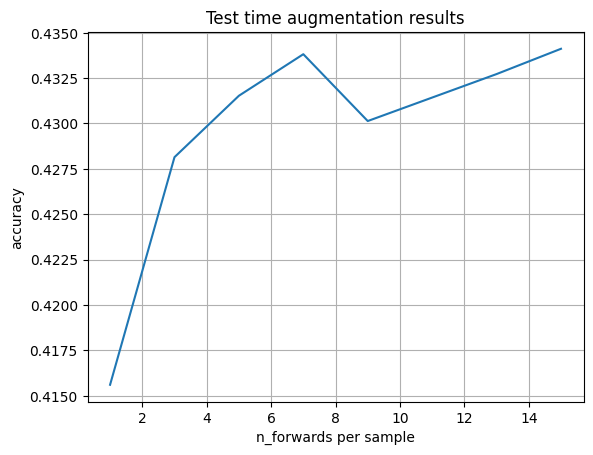

In [100]:
plt.plot(n_forwards, tta_accuracy)
plt.grid()
plt.xlabel('n_forwards per sample')
plt.ylabel('accuracy')
plt.title('Test time augmentation results')

Normally you should get 1-2% improvement of accuracy here.

## What's next?
Introducing of residual blocks played a big role in deep learning and allowed to train deep (and I mean really [DEEP](https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua#L2)) networks. Many modern architectures include such layer or its variation. For deeper understanding of influence of skip connections you can read the following papers:
1. ["Residual Networks Behave Like Ensembles of
Relatively Shallow Networks"](https://arxiv.org/pdf/1605.06431.pdf) - interesting point of view on residual blocks showing that statement "skip connections solves vanishing gradients problem" is ambigious in some way
2. ["Identity Mappings in Deep Residual Networks"](https://arxiv.org/pdf/1603.05027.pdf) ([short summary](https://towardsdatascience.com/resnet-with-identity-mapping-over-1000-layers-reached-image-classification-bb50a42af03e)) - study and comparison of different residual blocks variations showing that preserving "identity path" through the network improves quality
3. ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/pdf/1712.09913.pdf) - some attempts on loss function visualization showed how skip-connections affect loss landscape